In [259]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

from census import Census # This is new...

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Static Covid-19 Cases by County Map

The code below creates a static map illustrating the prevalence of Covid cases. The interactive map is now housed in the notebook ``us-covid-19-static-map.ipynv``

The underlying Covid-19 data is from reporting done by the New York Times and hosted in their data repository on github.

### Overview of code

Thansk to the [@nytimes](https://github.com/nytimes/covid-19-data). This proved to be very easy given my existing code associated with my project on the [trade war](https://github.com/mwaugh0328/consumption_and_tradewar). The code proceeds in several steps:

Thansk to the [@nytimes](https://github.com/nytimes/covid-19-data). This proved to be very easy given my existing code associated with my project on the [trade war](https://github.com/mwaugh0328/consumption_and_tradewar). The code proceeds in several steps:

1. Grabs the nytimes data. Their repository provides detailed explanations regarding geography etc. NYC in particular is treated as one region, not by county. 

2. Merge nytimes data with the geopandas dataframe, add in US Census data (currently just population), then some simple cleaning to prepare for maping.

3. Create a static map using geopandas.

### Prerequisites

- The code below assumes you have the correct shapefiles. If not, or you don't know what I'm talking about run ``download_shapefiles.ipynb`` which pull the correct shapefiles to make the map.

---

### Step \#1. Grab data from [nytimes repository](https://github.com/nytimes/covid-19-data)

Thank you for organizing this. It's very simple...

In [260]:
df = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv")

In [261]:
# For NYC we will assing it the Mannhatten fips code
# Then below to the other new york city counties we 
# assing them the same case and death data as New York city as a whole

nyc = df.county == "New York City"
df.loc[nyc,"fips"] = 36061

In [262]:
# Convert the date to a datetime object
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [263]:
latest_date = df.date.max()

In [264]:
latest_date = latest_date.strftime("%m/%d/%Y")

In [265]:
df.set_index("date", inplace = True)

In [266]:
dfall = df.loc[latest_date].copy()

**Important data note** The nytimes dataset reports **cumulative** cases, not the number reported each day. The very first version of this code messed this up. Now it is correct.

In [267]:
dfall[dfall.county == "New York City"]

,county,state,fips,cases,deaths
date,,,,,
2020-07-23,New York City,New York,36061.0,227517,22934


In [268]:
total = dfall.cases.sum()

print("Total US Covid-19 Cases", total, "as of", latest_date)

Total US Covid-19 Cases 4050126 as of 07/23/2020


In [269]:
total_deaths = dfall.deaths.sum()

print("Total US Covid-19 Deaths", total_deaths, "as of", latest_date)

Total US Covid-19 Deaths 144102 as of 07/23/2020


In [270]:
dfall[dfall["fips"] == 36061]

,county,state,fips,cases,deaths
date,,,,,
2020-07-23,New York City,New York,36061.0,227517,22934


###  Get US County and State, Shapefiles

The notebook ``download_shapefiles.ipynb`` downloads the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

The following code reads in the shape files and organizes them.

In [271]:
map_projection = "epsg:2163"

In [272]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\lake\\ne_10m_lakes.shx"

lake_map = gpd.read_file(county_shape)

lake_map = lake_map.to_crs({'init': map_projection})

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [273]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\land\\ne_50m_land.shx"

land_map = gpd.read_file(county_shape)

land_map = land_map.to_crs({'init': map_projection })

land_map = land_map.iloc[0:1200]

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [274]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': map_projection })

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [275]:
us_map["geometry"] = us_map["geometry"].simplify(200)
# This was important. The geometry in the tigerline file si
# too fine, orginal map was 350mb. simply basicly simplifies the geometry,
# making the map take up less memory and load faster. Still not sure
# what the number exactly means.

In [276]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

---

###  Step \#3 Merge and Clean

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [277]:
us_map = us_map.merge(dfall, left_on='area_fips',
                      right_on = "fips", how = "left", indicator = True)

The cell below fills in the NYC region with the NYC values. So in the hover map, when you hover over say Brookly, it will show the value for the NYC region. I then added a data note column that will inform the reader of this.

In [278]:
#Fill in Queens (36081), Bronx (36005, Richmond(36085), Brooklyn (36047)
nyc_counties = [36081,36005,36085,36047]

us_map.loc[us_map.area_fips.isin(nyc_counties), "deaths"] = us_map.loc[us_map.area_fips == 36061,"deaths"].values[0]

us_map.loc[us_map.area_fips.isin(nyc_counties), "cases"] = us_map.loc[us_map.area_fips == 36061,"cases"].values[0]

us_map["Notes"] = ""

all_nyc_counties = [36081,36005,36085,36047,36061]

us_map.loc[us_map.area_fips.isin(all_nyc_counties), "Notes"] = "NYC counties are treated as one region"

In [279]:
all_nyc_counties = [36081,36005,36085,36047,36061]

us_map.loc[us_map.area_fips.isin(all_nyc_counties)]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,INTPTLON,geometry,area_fips,county,state,fips,cases,deaths,_merge,Notes
1399,36,085,00974141,36085,Richmond,Richmond County,06,H6,G4020,408,...,-074.1398995,"POLYGON ((2134341.826 -162282.230, 2134160.958...",36085,NaN,NaN,NaN,227517.0,22934.0,left_only,NYC counties are treated as one region
2333,36,081,00974139,36081,Queens,Queens County,06,H6,G4020,408,...,-073.8380168,"POLYGON ((2150608.494 -152317.835, 2150329.771...",36081,NaN,NaN,NaN,227517.0,22934.0,left_only,NYC counties are treated as one region
2409,36,047,00974122,36047,Kings,Kings County,06,H6,G4020,408,...,-073.9506398,"POLYGON ((2146042.330 -142774.194, 2145432.081...",36047,NaN,NaN,NaN,227517.0,22934.0,left_only,NYC counties are treated as one region
2446,36,061,00974129,36061,New York,New York County,06,H6,G4020,408,...,-073.9701871,"MULTIPOLYGON (((2144820.475 -136214.749, 21450...",36061,New York City,New York,36061.0,227517.0,22934.0,both,NYC counties are treated as one region
3162,36,005,00974101,36005,Bronx,Bronx County,06,H6,G4020,408,...,-073.8529390,"POLYGON ((2147363.976 -112631.535, 2147425.579...",36005,NaN,NaN,NaN,227517.0,22934.0,left_only,NYC counties are treated as one region


In [280]:
#us_map[["NAME","NAMELSAD","county","state", "cases"]].head(48)

I'm from Alaska, so this next step is always painfull. Drop states and territories who are not part of the "lower 48", contiguous US. Still not clear how fix this in geopandas.

In [281]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

us_map.drop(drop_list, inplace = True)

In [282]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': map_projection })

state_map["geometry"] = state_map["geometry"].simplify(200)

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [283]:
state_fp_dict = dict(zip(state_map.STATEFP, state_map.STUSPS))

In [284]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

In [285]:
us_map.reset_index(inplace = True)

In [286]:
us_map["STSPS"] = us_map["STATEFP"].map(state_fp_dict)

In [287]:
us_map["NAME"] = us_map["NAME"] + ", " + us_map["STSPS"]

In [288]:
us_map.set_index("STATEFP", inplace = True)

In [289]:
#us_map["cases"].replace("nan", np.nan, inplace = True)

#us_map["cases"] = us_map["cases"].str.replace(',','')

#us_map["cases"] = us_map["cases"].astype(int)

us_map["cases_label"] = us_map["cases"].round(0)

us_map["cases_label"] = us_map["cases_label"].map('{:,.0f}'.format)

us_map["deaths_label"] = us_map["deaths"].round(0)

us_map["deaths_label"] = us_map["deaths_label"].map('{:,.0f}'.format)

#### Add Census Data

Here I add this in. MY api key is posted here, please be respectfull of it.

In [290]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key, # don't abuse this.

c = Census(my_api_key)
# This will create an object c which has methods associated with it.
# We will see  these below.

code = ("NAME","B01001_001E") 
# Get more stuff from the cencuss if we want...

county_2017 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2017))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
        
county_2017 = county_2017.rename(columns = {"B01001_001E":"2017_population"})

county_2017["GEOFIPS"] = (county_2017["state"] + county_2017["county"]).astype(int)

county_2017["2017_population"] = county_2017["2017_population"].astype(float)

county_2017.set_index(["GEOFIPS"], inplace = True)

In [291]:
county_2017.head()

,NAME,2017_population,state,county
GEOFIPS,,,,
72047,"Corozal Municipio, Puerto Rico",34933.0,72,047
72095,"Maunabo Municipio, Puerto Rico",11297.0,72,095
72111,"Peñuelas Municipio, Puerto Rico",21661.0,72,111
72113,"Ponce Municipio, Puerto Rico",148863.0,72,113
72131,"San Sebastián Municipio, Puerto Rico",38970.0,72,131


---
### Merge the Census and final preperations for mapping

In [292]:
us_map = us_map.merge(county_2017[["2017_population"]], 
                      left_on='area_fips', right_on = "GEOFIPS", how = "left")

In [293]:
us_map["pop_label"] = us_map["2017_population"].map('{:,.0f}'.format)

In [294]:
q_cases = [0,1,5,10,100,250,500,1000,5000,10000,np.inf]

In [295]:
us_map["q_cases"]= pd.cut(us_map["cases"],q_cases, labels=range(0,10))
us_map["q_deaths"]= pd.cut(us_map["deaths"],q_cases, labels=range(0,10))

In [296]:
us_map["q_deaths"].max()

9

In [297]:
us_map["cases_label"].replace("nan", "None reported", inplace = True)
us_map["deaths_label"].replace("nan", "None reported", inplace = True)

The final issue is to create the borders associated with the great lakes. The issue is that the tigerline shape files just extend boundries into the waterline. And the associated coastline maps are (i) not polygons and (ii) looked messed up. So per above, I found another shape file of lakes. Then I will use geopandas built in set operations to essentially "punch out" the holes associated with the great lakes. 

[https://geopandas.org/set_operations.html](https://geopandas.org/set_operations.html)

**Note** for teaching purposes, it's worth messing around with the ``how`` operations to understand what is going on here.

In [298]:
# This operation will take care of the coastline

us_map = gpd.overlay(us_map, land_map,  how='intersection')

In [299]:
great_lakes = ["Lake Superior", "Lake Michigan", "Lake Erie","Lake Superior""Lake Huron"]

us_map = gpd.overlay(us_map, lake_map[lake_map.name.isin(great_lakes)],  how='difference')
# this is the key operation...note that the order matters on the difference operation. output is same 

In [300]:
state_map = gpd.overlay(state_map, land_map,  how='intersection')

state_map = gpd.overlay(state_map, lake_map[lake_map.name.isin(great_lakes)],  how='difference')
# Do the same thing for the state map

---

### Step \# 4. Create a Static map

Below is a set of code and lots of tricks to make a nice looking static map using Geopandas build in functionality. The output file is a ``.png`` file. Should enhance this by adding the date and generating the maps by date.

C:\Users\mwaugh\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


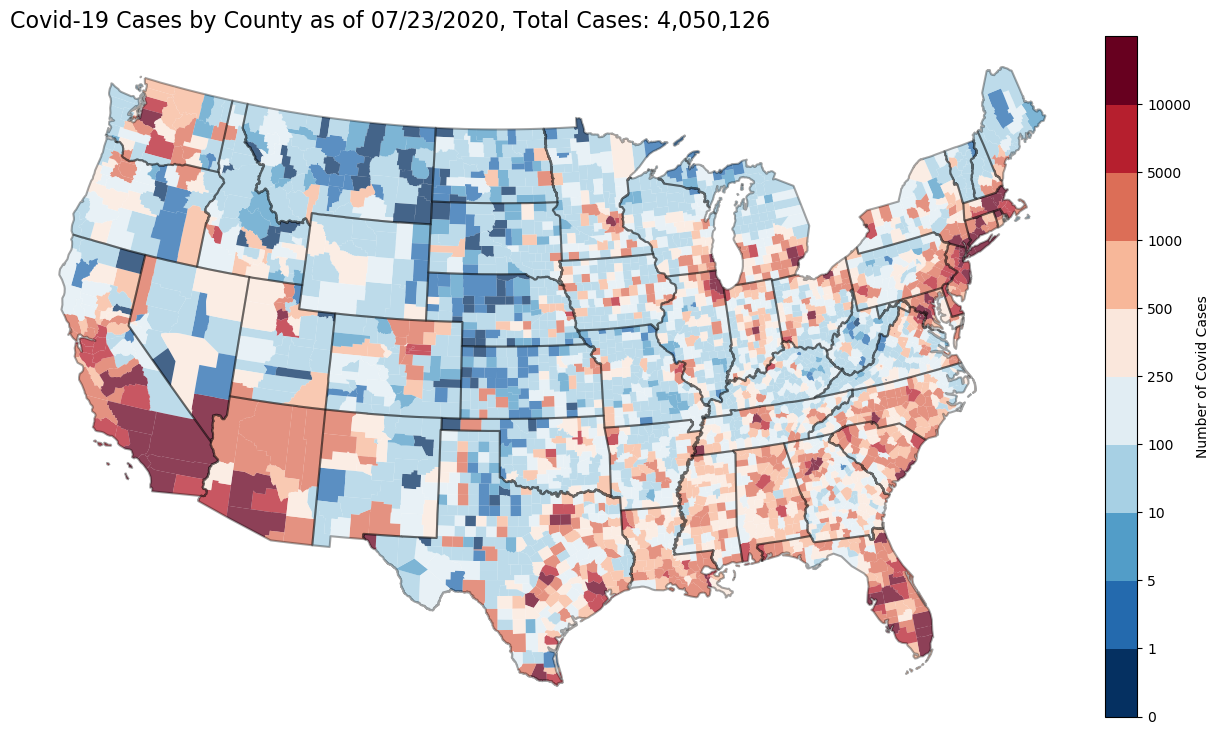

In [301]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

#us_map[us_map.q_cases.isna()].plot(alpha = 0.25, color = "grey", ax = ax,)

us_map.plot(column='q_cases', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_cases.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Number of Covid Cases')
cbr.set_alpha(0.15)

cbr.set_ticks([0, 0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80, 0.90])
cbr.set_ticklabels(q_cases, update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#coast_map.plot(color='k', edgecolor='k', alpha = 0.25, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

title = "Covid-19 Cases by County as of " + latest_date + ", Total Cases: " + f"{total:,d}"
title_death = "Covid-19 Deaths by County as of " + latest_date + ", Total Deaths: " + f"{total_deaths:,d}"
ax.set_title(title, fontsize = 16, loc= "left" )

plt.savefig("covid-19-map.png", bbox_inches = "tight", dip = 1200)

plt.show()